# Predicting interest rates from Federal Reserve documents
## Preprocessing II (Vol. 3)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

## Clean Text Data

In [389]:
import os
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [390]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [391]:
#if IN_COLAB:
#  # Uninstall existing versions:
#  !pip uninstall bs4 -y
#  !pip uninstall textract -y
#  !pip uninstall numpy -y
#  !pip uninstall pandas -y
#  !pip uninstall requests -y
#  !pip uninstall tqdm -y
#  !pip uninstall nltk -y
#  !pip uninstall quandl -y
#  !pip uninstall scikit-plot -y
#  !pip uninstall seaborn -y
#  !pip uninstall sklearn -y
#  !pip uninstall torch -y
#  !pip uninstall transformers -y
#  !pip uninstall wordcloud -y
#  !pip uninstall xgboost -y
#  
#  # Install packages:
#  !pip install bs4==0.0.1
#  !pip install textract==1.6.3
#  !pip install numpy==1.19.4
#  !pip install pandas==1.1.4
#  !pip install requests==2.24.0
#  !pip install tqdm==4.51.0
#  !pip install nltk==3.5
#  !pip install quandl==3.5.3
#  !pip install scikit-plot==0.3.7
#  !pip install seaborn==0.11.0
#  !pip install sklearn==0.0
#  !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#  !pip install transformers==3.5.0
#  !pip install wordcloud==1.8.0
#  !pip install xgboost==1.2.1
#  os.kill(os.getpid(), 9)


In [392]:
# Python libraries
import pprint
import datetime as dt
import re
import io
import os
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter
import xgboost as xgb
import codecs
pprint.pprint(sys.path)

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="darkgrid")
#plt.style.use('ggplot')

# Import Scikit-learn models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

# Import Transformers
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [393]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
  graph_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/graphs/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'
  graph_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/graphs/'


In [394]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)


# Previous

## Define Utility Functions

In [395]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [396]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [397]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [398]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [399]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons


,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [400]:
file = open(preprocessed_dir + 'fomc_calendar.pickle', 'rb')
fomc_calendar = pickle.load(file)
file.close()

print(type(fomc_calendar))
fomc_calendar

<class 'pandas.core.frame.DataFrame'>


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged
date,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0
...,...,...,...,...,...,...,...,...
2021-06-16,False,True,False,Jerome Powell,NaN,NaN,0,0
2021-07-28,False,False,False,Jerome Powell,NaN,NaN,0,0
2021-09-22,False,True,False,Jerome Powell,NaN,NaN,0,0


In [401]:
# #Check calendar
#fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1998, 1, 27)]

### Statement

In [402]:
file = open(fomc_dir + 'statement.pickle', 'rb')
statement_df = pickle.load(file)
file.close()

In [403]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])
statement_df.shape

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

(194, 4)

### Meeting Minutes

In [404]:
file = open(fomc_dir + 'minutes.pickle', 'rb')
minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(223, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
...,...,...,...,...
218,2020-06-10,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
219,2020-07-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
220,2020-09-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
221,2020-11-05,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes


In [405]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [406]:
file = open(fomc_dir + 'meeting_script.pickle', 'rb')
meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(282, 4)


,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...,other,FOMC Meeting Transcript
2,1980-03-18,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav...",other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER...",other,FOMC Meeting Transcript
...,...,...,...,...
277,2014-06-18,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan\rFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and\rLael, but both hav...",Janet Yellen,FOMC Meeting Transcript
278,2014-07-30,"CHAIR YELLEN. Good morning, everybody. I would like to begin today’s meeting by\rgiving the floor to President Fisher, who asked if he could take a minute to address the group.\r\n\n[SECTION]\n\nM...",Janet Yellen,FOMC Meeting Transcript
279,2014-09-17,"CHAIR YELLEN. Good morning, everybody.\rOur first two items this morning will be conducted in a joint meeting between the FOMC\rand the Board. I need a motion to close the Board meeting.\r\n\n[SEC...",Janet Yellen,FOMC Meeting Transcript
280,2014-10-29,"CHAIR YELLEN. I’d like to call this meeting to order. Before turning to our agenda,\rI’d like to say a few words about our communications with the public. Many of you will recall\rthat in June 201...",Janet Yellen,FOMC Meeting Transcript


In [407]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

the Board meeting.

[SECTION]

MR. FISCHER. So moved.

[SECTION]

Simon to give us his report on market developments.

[SECTION]

to answer questions before moving on to Lorie’s part.

[SECTION]

CHAIR YELLEN. Questions for Simon? President Fisher.

[SECTION]

want to clarify that. So it’s mainly energy-driven.

[SECTION]

right.

[SECTION]

because you referenced them just now.

[SECTION]



[SECTION]

in mortgage-backed securities. Is that correct?

[SECTION]

MR. POTTER. It’s $2.5 trillion in Treasuries, I thought.

[SECTION]

Treasury redemptions in 2015, so nothing to speak of—

[SECTION]

MR. POTTER. That’s correct.

[SECTION]

for 2015 will be approximately $20 billion per month.

[SECTION]

MR. POTTER. Maybe a little bit higher, but about that level.

[SECTION]

net issuance.

[SECTION]

MR. POTTER. Correct.

[SECTION]

So it’s really taking five years, and, therefore, we would reduce by $900 billion over that fiveyear period. Correct?

[SECTION]

MR. POTTER. Yes. That’s the po

### Press Conference Transcripts

In [408]:
file = open(fomc_dir + 'presconf_script.pickle', 'rb')
presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(45, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th...",Ben Bernanke,FOMC Press Conference Transcript
...,...,...,...,...
40,2020-06-10,"CHAIR POWELL. Good afternoon, everyone, and thanks for joining us. Our country\rcontinues to face a difficult and challenging time, as the pandemic is causing tremendous\rhardship here in the Unit...",Jerome Powell,FOMC Press Conference Transcript
41,2020-07-29,CHAIR POWELL. Good afternoon. The pandemic continues to cause tremendous\rhuman and economic hardship here in the United States and around the world. The most\rimportant response to this public he...,Jerome Powell,FOMC Press Conference Transcript
42,2020-09-16,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th...",Jerome Powell,FOMC Press Conference Transcript
43,2020-11-05,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th...",Jerome Powell,FOMC Press Conference Transcript


In [409]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

this difficult period will be as robust as possible. Thank you. I look forward to your questions.

[SECTION]

MICHELLE SMITH. Thank you. Rich Miller.

[SECTION]

further progress” toward the Committee’s maximum-employment and price-stability goals?

[SECTION]

when we would actually consider gradually tapering the pace of purchases.

[SECTION]

of the asset purchases at this time, given what you see as a very challenging period ahead?

[SECTION]

long as it takes until the job is well and truly done. No one should doubt that.

[SECTION]

RICH MILLER. Thank you.

[SECTION]

MICHELLE SMITH. Thank you. Nick Timiraos.

[SECTION]

maturities while simultaneously tapering the monthly purchase amounts?

[SECTION]

on our list of, of possibilities.

[SECTION]

NICK TIMIRAOS. Thank you.

[SECTION]

MICHELLE SMITH. Thank you. Victoria.

[SECTION]

have any plans for any future facilities that don’t require Treasury backing?

[SECTION]

of—during the Global Financial Crisis also didn’t have any.


### Speech

In [410]:
file = open(fomc_dir + 'speech.pickle', 'rb')
speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1500, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
...,...,...,...,...
1495,2020-12-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Strengthening the Financial System to Meet the Challenge of Climate Change
1496,2021-01-08,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Vice Chair Richard H. Clarida,U.S. Economic Outlook and Monetary Policy
1497,2021-01-12,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Supporting Responsible Use of AI and Equitable Outcomes in Financial Services
1498,2021-01-13,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Full Employment in the New Monetary Policy Framework


In [411]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [412]:
file = open(fomc_dir + 'testimony.pickle', 'rb')
testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(443, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
...,...,...,...,...
438,2020-09-08,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Testimony by Sheila Clark, Program Director, Office of Diversity and Inclusion",Diversity and Inclusion
439,2020-09-17,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Kent Hiteshew, Deputy Associate Director, Division of Financial Stability",Municipal Liquidity Facility
440,2020-09-22,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chair Jerome H. Powell,"Coronavirus Aid, Relief, and Economic Security Act"
441,2020-11-10,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Vice Chair for Supervision Randal K. Quarles,Supervision and Regulation Report


In [413]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Statements

In [414]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [415]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [416]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  0
Shape of the dataframe:  (195, 13)


In [417]:
# Check the returned dataframe
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1,4.25,1994-07-06,0,4.25,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1,4.75,1994-09-27,0,4.75,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,statement,2020-08-27,FOMC Statement,Jerome Powell,603,0,NaN,2020-09-16,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and 

In [418]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
190,statement,2020-08-27,FOMC Statement,Jerome Powell,603,0,NaN,2020-09-16,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
191,statement,2020-09-16,FOMC Statement,Jerome Powell,700,0,NaN,2020-11-05,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
192,statement,2020-11-05,FOMC Statement,Jerome Powell,618,0,NaN,2020-12-16,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
193,statement,2020-12-16,FOMC Statement,Jerome Powell,630,0,NaN,2021-01-27,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."


In [419]:
#x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
#fomc_calendar.loc[fomc_calendar['date'].iloc[:] > x]

In [420]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,statement,2020-08-27,FOMC Statement,Jerome Powell,387,0,NaN,2020-09-16,0,NaN,"Following an extensive review that included numerous public events across the country, the Federal Open Market Committee (FOMC) on Thursday announced the unanimous approval of updates to its State...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary an

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


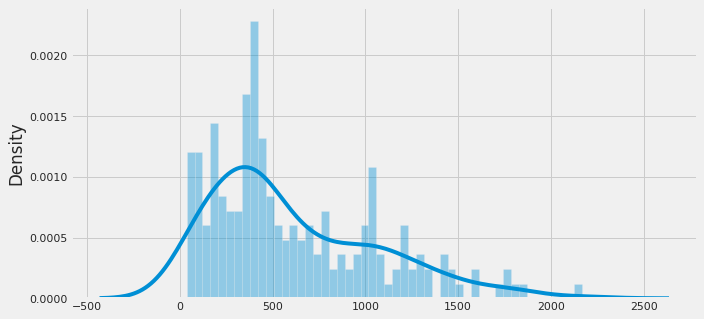

In [421]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [422]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
825,statement,2020-08-27,FOMC Statement,Jerome Powell,87,0,NaN,2020-09-16,0,NaN,communications htm Finally the Committee explored the range of issues that were brought to light during the course of the review in five consecutive meetings beginning in July Analytical staff wor...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
826,statement,2020-09-16,FOMC Statement,Jerome Powell,200,0,NaN,2020-11-05,0,NaN,The COVID pandemic is causing tremendous human and economic hardship across the United States and around the world Economic activity and employment have picked up in recent months but remain well ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
827,statement,2020-09-16,FOMC Statement,Jerome Powell,200,0,NaN,2020-11-05,0,NaN,these outcomes are achieved The Committee decided to keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor mar...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
828,statement,2020-09-16,FOMC Statement,Jerome Powell,134,0,NaN,2020-11-05,0,NaN,that could impede the attainment of the Committee's goals The Committee's assessments will take into account a wide range of information including readings on public health labor market conditions...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
829,statement,2020-11-05,FOMC Statement,Jerome Powell,200,0,NaN,2020-12-16,0,NaN,The COVID pandemic is causing tremendous human and economic hardship across the United States and around the world Economic activity and employment have continued to recover but remain well below ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
830,statement,2020-11-05,FOMC Statement,Jerome Powell,186,0,NaN,2020-12-16,0,NaN,achieved The Committee decided to keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor market conditions have...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, M

### Filter out by keywords

In [423]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(107, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...","[The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sh...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.","[In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.]","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...","[For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.50,1997-05-20,0,5.50,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...","[For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 p...","For immediate release\n\n\n\n\n\n\r\n\r\n\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage poin..."
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...","[For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1...","For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage poin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,statement,2020-06-10,FOMC Statement,Jerome Powell,83,0,0.00,2020-07-29,0,0.00,"The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable risks to the economic outlook over the medium term. In ...","[The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable risks to the economic outlook over 

In [424]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

### Minutes

In [425]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [426]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  0
Shape of the dataframe:  (223, 13)


In [427]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,0,3.0,1993-02-18,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,0,3.0,1993-05-18,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,0,3.0,1993-07-07,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,0,3.0,1993-08-17,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,0,3.0,1993-09-21,0,3.0,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,minutes,2020-06-10,FOMC Meeting Minutes,Jerome Powell,9995,0,0.0,2020-07-29,0,0.0,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Re

In [428]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
220,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,9957,0,NaN,2020-11-05,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
221,minutes,2020-11-05,FOMC Meeting Minutes,Jerome Powell,9365,0,NaN,2020-12-16,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
222,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,8133,0,NaN,2021-01-27,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


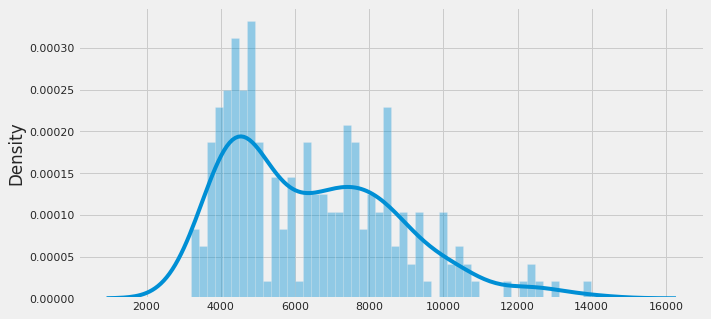

In [429]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [430]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
220,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,9957,0,NaN,2020-11-05,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
221,minutes,2020-11-05,FOMC Meeting Minutes,Jerome Powell,9365,0,NaN,2020-12-16,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
222,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,8133,0,NaN,2021-01-27,0,NaN,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."


Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [431]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [432]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [433]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [434]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(8249, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8239,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,the Committee's maximum employment and price stability goals In their discussions of this change participants noted that the new guidance regarding balance sheet policy brought the statement's ref...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8240,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,Reserve's balance sheet A couple of participants remarked that against this background it was important to convey to the public that the federal funds rate remained the Committee's primary policy ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8241,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,and nearly all favored maintaining the current composition of purchases although a couple of participants indicated that they were open to weighting purchases of Treasury securities toward longer ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8242,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,that once such progress had been attained a gradual tapering of purchases could begin and the process thereafter could generally follow a sequence similar to the one implemented during the large s...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8243,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,the U S economy in this challenging time thereby promoting its maximum employment and price stability goals Members also stated that the path of the economy would depend significantly on the cours...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8244,minutes,2020-12-16,FOMC Meeting Minutes,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,achieved All members agreed to maintain the target range for the federal funds rate at to percent and they expected that it would be appropriate to maintain this target range until labor market co...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., F

### Filter out by keywords

In [435]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(223, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,0,3.0,1993-02-18,0,3.0,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,0,3.0,1993-05-18,0,3.0,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,0,3.0,1993-07-07,0,3.0,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,0,3.0,1993-08-17,0,3.0,"Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with me...","[Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with m...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,0,3.0,1993-09-21,0,3.0,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,minutes,2020-06-10,FOMC Meeting Minutes,Jerome Powell,2598,0,0.0,2020-07-29,0,0.0,"Discussion of Forward Guidance, Asset Purchases, and Yield Curve Caps or TargetsParticipants discussed tools for conducting monetary policy when the federal funds rate is at its effective lower bo...","[Discussion of Forward Guidance, Asset Purchases, and Yield Curve Caps or TargetsParticipants discussed tools for conducting monetary policy when the federal funds rate is at its effective lower b...",

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


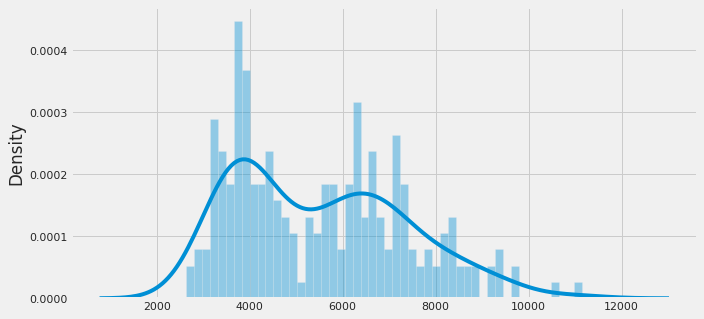

In [436]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [437]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script

In [438]:
# Sample
print(presconf_script_df['contents'][2])

Thank you for your patience, and I would be happy to take your questions.

[SECTION]

policy, in your opinion?

[SECTION]

at least, not proved to be very valid.

[SECTION]

STEVE LIESMAN. Was the letter appropriate?

[SECTION]

going to do.

[SECTION]

And what are your views on the advantages and disadvantages of that approach?

[SECTION]

date—at this time—any radical change in framework. We are going to stay within the dualmandate approach that we’ve been using until this point.

[SECTION]

economy?

[SECTION]

address inequality per se.

[SECTION]

how people should interpret those two messages?

[SECTION]

necessarily move in mid-2013 with those conditions prevailing that you described.

[SECTION]

proposal?

[SECTION]

conditions were appropriate. So the answer is yes, we would certainly look at that.

[SECTION]

know that U.S. companies don’t about investing in the U.S.?

[SECTION]

but it’s still obviously too low to be consistent with a full employment economy.

[SECTION]

th

In [439]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  0
Shape of the dataframe:  (45, 13)


In [440]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8761,0,0.0,2011-06-22,0,0.0,"CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly econ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7363,0,0.0,2011-08-01,0,0.0,"CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and ou...","[CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and o...","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7358,0,0.0,2011-11-28,0,0.0,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your ...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10134,0,0.0,2012-03-13,0,0.0,CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and st...,[CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and s...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7678,0,0.0,2012-06-20,-1,0.0,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the co...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the c...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,presconf_script,2020-06-10,FOMC Press Conference Transcript,Jerome Powell,10538,0,0.0,2020-07-29,0,0.0,"CHAIR POWELL. Good afternoon, everyone, and thanks for joining us. Our countrycontinues to face a difficult and challenging time, as the pandemic is causing tremendoushardship here 

In [441]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
42,presconf_script,2020-09-16,FOMC Press Conference Transcript,Jerome Powell,11042,0,NaN,2020-11-05,0,NaN,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the be...","[CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the b...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."
43,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,8520,0,NaN,2020-12-16,0,NaN,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the be...","[CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the b...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."
44,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,10330,0,NaN,2021-01-27,0,NaN,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the be...","[CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the b...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."


### Split by speakers
Scripts contain words from different people, so split by the speaker

In [442]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)

In [443]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1653, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


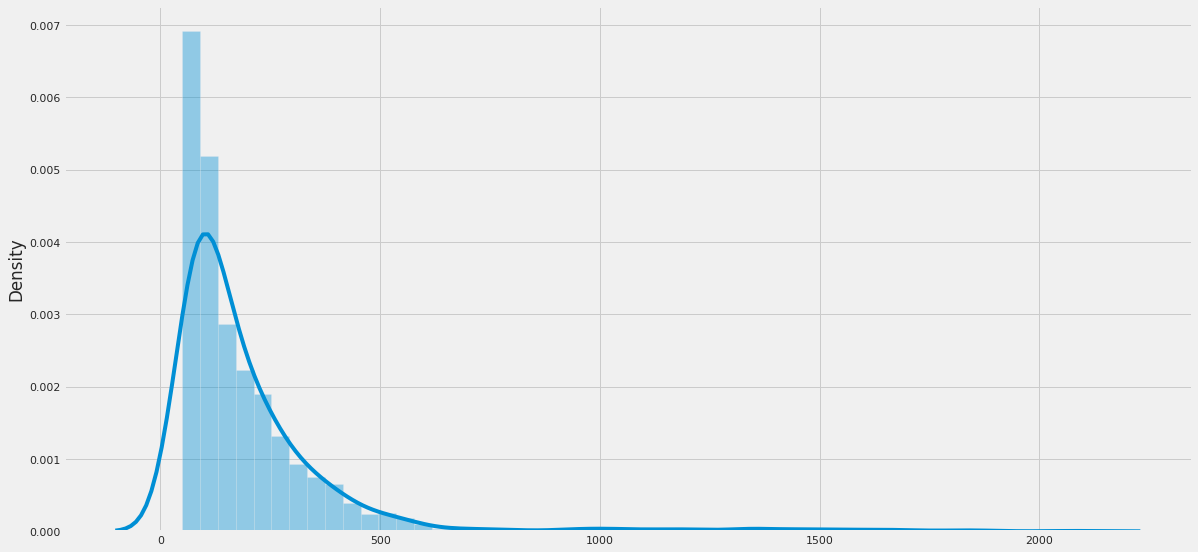

In [444]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [445]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1509,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,185,0,0.0,2011-06-22,0,0.0,"You’re correct. We haven’t seen the GDP number yet. Butwe, like most private-sector forecasters, are expecting a relatively weak number for the firstquarter, maybe something a little under 2 perce...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,303,0,0.0,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in amoderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed,sustainable, as we believe it is. And we’ll also...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,197,0,0.0,2011-06-22,0,0.0,"Thanks, Steve. First, I should start by saying that theSecretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar andSecretary Geithner had some words yesterday. Let m...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,158,0,0.0,2011-06-22,0,0.0,"Well, the dollar—the dollar fluctuates. One factor, forexample, that has caused fluctuations that have been quite extreme during the crisis has been thesafe-haven effect. So, for example, during t...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,110,0,NaN,2021-01-27,0,NaN,"I think the main thing that those companies need is a—is a robustrecovery—a strong, robust recovery. And so we, we contribute to that through highlyaccommodative monetary policy, thr

In [446]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (980, 13)



After (45, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,7047,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections a...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
21,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,5635,0,0.0,2011-08-01,0,0.0,"Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy. ...","[Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy....","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
40,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,5519,0,0.0,2011-11-28,0,0.0,"Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indica...","[Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indic...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
62,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,7488,0,0.0,2012-03-13,0,0.0,Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finally...,[Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finall...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
81,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,5453,0,0.0,2012-06-20,-1,0.0,"Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econom...","[Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econo...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


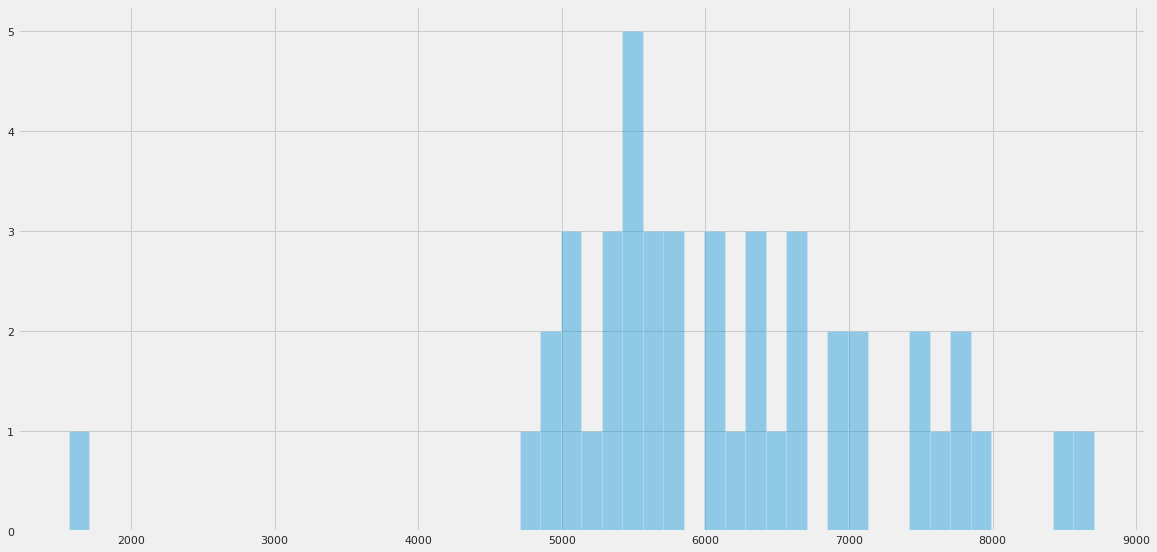

In [447]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [448]:
# Check text
print(presconf_script_chair_day_df['text'][0])

Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections also beingreleased today, and I’ll place today’s policy decision in the context of the Committee’sprojections and the Federal Reserve’s statutory mandate to foster maximum employment andprice stability. I’ll then be glad to take your questions. Throughout today’s briefing, my goalwill be to reflect the consensus of the Committee, while taking note of the diversity of views asappropriate. Of course, my remarks and interpretations are my own responsibility.In its policy statement released earlier today, the Committee announced, first, that it ismaintaining its existing policy of reinvesting principal payments from its security holdings, and,second, that it will complete its planned purchases of $600 billion of longer-term Treasurysecurities by the end of the current quarter. Of course, going forwa

### Split contents to max 200 words

In [449]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(1843, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
1838,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,s you know that s that s maybe not as relevant in aworld where we think the year Treasury is going to be lower than it s been historically froma from a return perspective You know we look at we al...,"[Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the beginning of th...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."
1839,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,are unemployed But you know with the CARES Act Congressreplaced a lot of lost income You know it s very important that that the economy gets strongagain I mean the the ultimate thing to support fi...,"[Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the beginning of th...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."
1840,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,monitoring these prices for that and and have published our our framework and you know we ll be held accountable for what we saw and what we missed So we workvery hard at it So people who people w...,"[Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the beginning of th...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."
1841,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,200,0,NaN,2021-01-27,0,NaN,now inthe in the you know some part of of an economic crisis And the fact that Congress isdebating a fairly large bill today suggests that that you know suggests that something fairlysubstantial i...,"[Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the beginning of th...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."
1842,presconf_script,2020-12-16,FOMC Press Conference Transcript,Jerome Powell,170,0,NaN,2021-01-27,0,NaN,it through those eyes Again these are these areissues for Congress But you know I ll just say in the near term I think fiscal the case for forfiscal is is strong And I m certainly hoping I think i...,"[Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us—maximum employment andprice stability. Since the beginning of th...","CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th..."


### Filter out by keywords

In [450]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(45, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,3219,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections a...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,2177,0,0.0,2011-08-01,0,0.0,"Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy. ...","[Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy....","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,2278,0,0.0,2011-11-28,0,0.0,"Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indica...","[Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indic...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,4426,0,0.0,2012-03-13,0,0.0,Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finally...,[Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finall...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,2050,0,0.0,2012-06-20,-1,0.0,"Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econom...","[Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econo...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,presconf_script,2020-06-10,FOMC Press Conference Transcript,Jerome Powell,1908,0,0.0,2020-07-29,0,0.0,"Good afternoon, everyone, and thanks for joining us. Our countrycontinues to face a difficult and challenging time, as the pandemic is causing tremendoushardship here in the United St

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


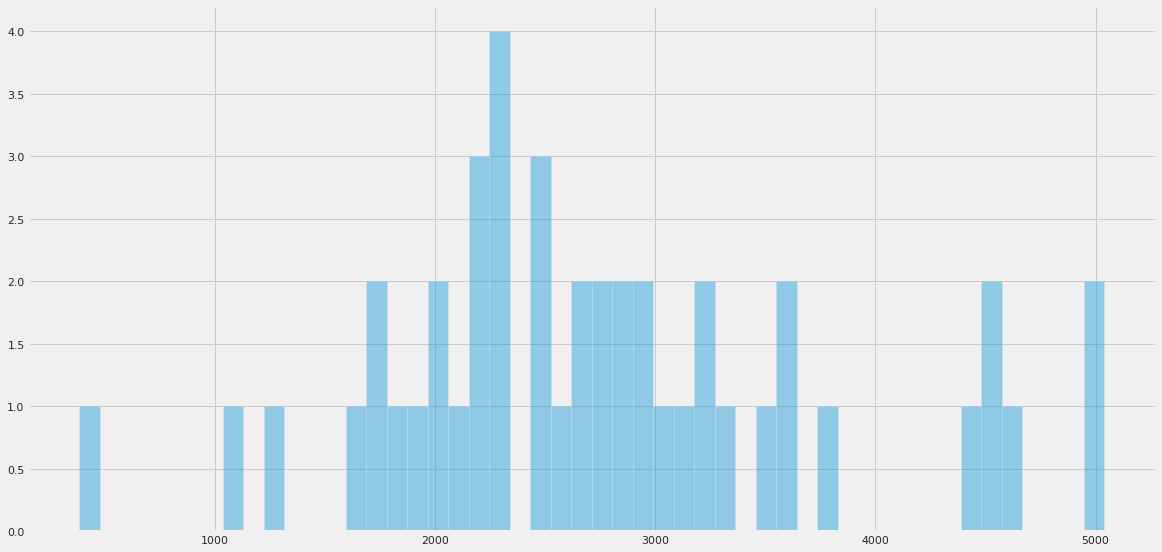

In [451]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [452]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script

In [453]:
meeting_script_df.head()

,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...,other,FOMC Meeting Transcript
2,1980-03-18,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav...",other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER...",other,FOMC Meeting Transcript


In [454]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')

No rate decision found:  23
Shape of the dataframe:  (282, 13)


In [455]:
# Sample
print(meeting_script_df['contents'][2])

--and we need a nomination.

[SECTION]

of the FOMC!

[SECTION]

CHAIRMAN VOLCKER.

[SECTION]

MR. PARTEE.

[SECTION]



[SECTION]

that way!

[SECTION]



[SECTION]

Chairman.

[SECTION]

Vice Chairman of the FOMC.

[SECTION]

date. Is there a second?

[SECTION]



[SECTION]

the nominees.

[SECTION]

That's the list, Mr. Chairman.

[SECTION]

plenitude of Davises--pardon me?

[SECTION]



[SECTION]

motion to that effect?

[SECTION]



[SECTION]

[reappointment them]?

[SECTION]



[SECTION]

have a motion?

[SECTION]



[SECTION]

CHAIRMAN VOLCKER.

[SECTION]



[SECTION]

since the last meeting, Mr. Pardee.

[SECTION]



[SECTION]

price of gold. Would that include any major commercial banks?

[SECTION]

past from the U.S. Treasury.

[SECTION]



[SECTION]

they can withstand such losses.

[SECTION]

dollar to go up in the face of that?

[SECTION]

bearish.

[SECTION]

of that?

[SECTION]

amounts.

[SECTION]

absence of intervention.

[SECTION]

[the dollar] has been pretty steady

In [456]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,NaN,NaT,<NA>,NaN,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,NaN,NaT,<NA>,NaN,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We haveth...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...","[CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your f...","CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes., MR. SCHULTZ.So moved., CHAIRMAN VOLCKER., MS. TEETERS.WeDo we have a second?Second., CHAIRMAN VOLCKER. Without...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,0,0.0,2014-07-30,0,0.00,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have ve...","[CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: 

In [457]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,NaN,NaT,<NA>,NaN,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,NaN,NaT,<NA>,NaN,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We haveth...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...","[CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your f...","CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes., MR. SCHULTZ.So moved., CHAIRMAN VOLCKER., MS. TEETERS.WeDo we have a second?Second., CHAIRMAN VOLCKER. Without...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,meeting_script,1982-02-02,FOMC Meeting Transcript,other,55066,<NA>,NaN,NaT,<NA>,NaN,"MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL.related charts--see Appendix.][Statements and[SECTION]CHAIRMAN VOLCKER. Do we have any comments or questions onhow these people see things?I have a quest...","[MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL.related charts--see Appendix.][Statements and

(282, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


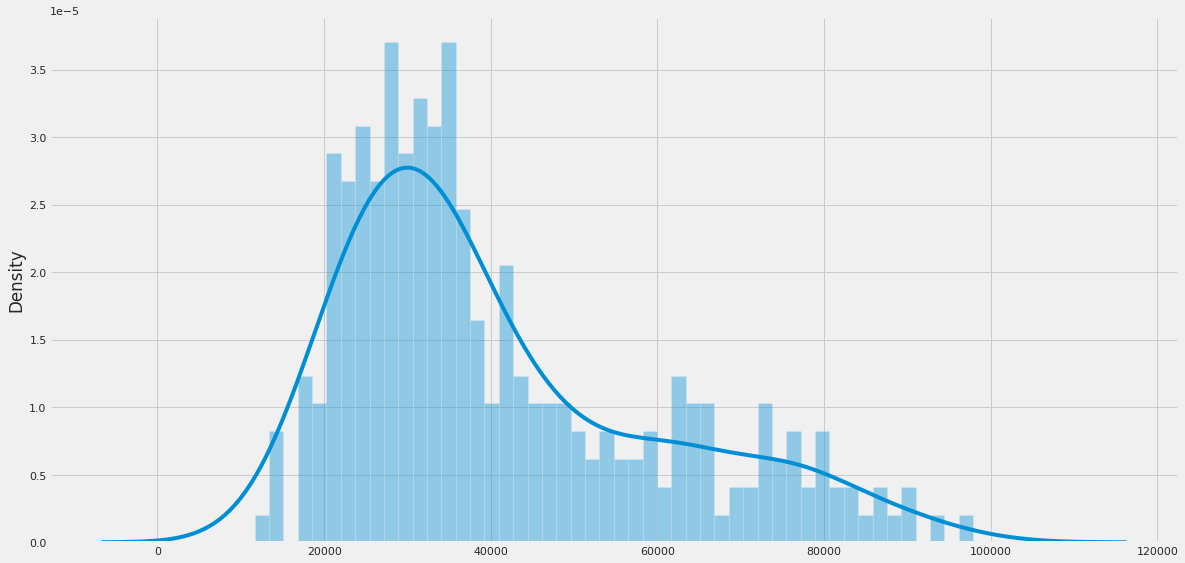

In [458]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [459]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

Streaming output truncated to the last 5000 lines.

not matched:  MR. HOENIG.Thank you.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.The inflation blip but not the nominal GDPblip?
1994-07-06 00:00:00

not matched:  MR. KOHN.I call on Mr. Kohn.[Statement--See Appendix.]
1994-07-06 00:00:00

not matched:  MR. KOHN.I think the models embody a vertical long-runPhillips curve; it takes a while for it to come out here.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Into the next millennium!If you had not noticed that the inflation
1994-07-06 00:00:00

not matched:  MR. KOHN.But never backwards?No.Only the coefficient is unchanged even
1994-07-06 00:00:00

not matched:  MR. KOHN.stretched out--In this time period, that's right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.No, go ahead, please finish.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.And when will we ever pay the price?
1994-07-06 00:00:00

not matched:  MR. LINDSEY.But t

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMA,4,<NA>,NaN,NaT,<NA>,NaN,VOLCKER.securities] since when?,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,25,<NA>,NaN,NaT,<NA>,NaN,"Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
2,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. AXILROD,1205,<NA>,NaN,NaT,<NA>,NaN,"Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how a...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
3,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,31,<NA>,NaN,NaT,<NA>,NaN,"I'm sure that's crystal clear!So, Ithink it's time to raise questions--not just on the details of Peter'soperations, but questions that bear upon the operating techniquesgenerally. Governor Partee.","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
4,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. PARTEE,107,<NA>,NaN,NaT,<NA>,NaN,"Well, just a comment. I think I understood thedirection of your adjustments, Steve, as you went through this. But Icertainly don't understand it from this table on the second page. Ican't make out...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88214,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,79,0,0.0,2016-01-27,0,0.25,"Thank you. Okay. I think the main open issue in the statement is thebracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eightpeople propose removing it. I’m cert...","[CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The firstitem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to closethe Board meeting., ...","CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first\ritem we are going

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [460]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (88219, 13)
After:  (47498, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


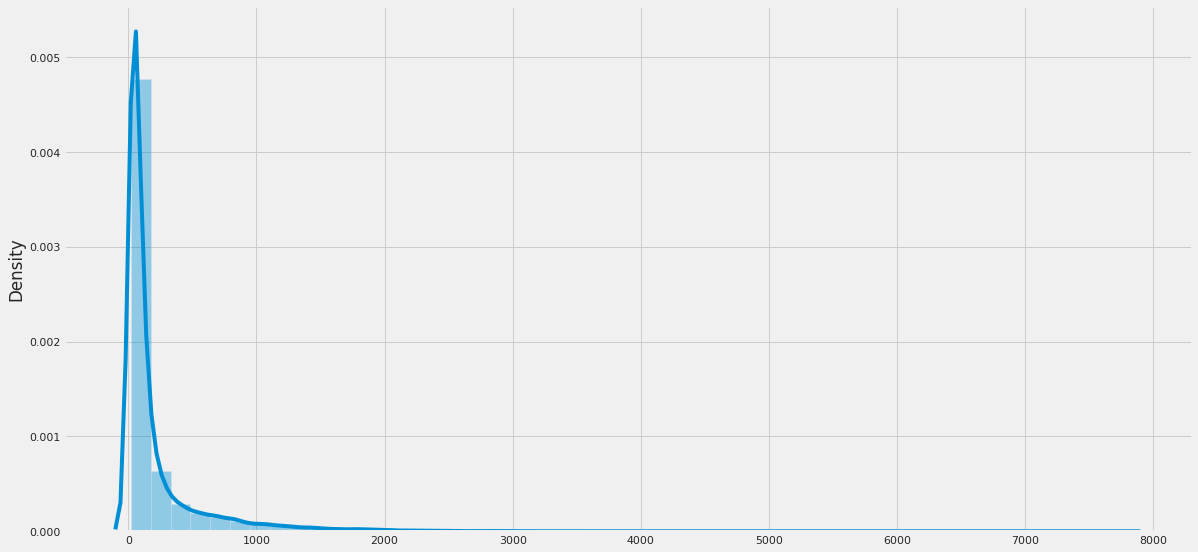

In [461]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [462]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year.V...,[VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year....,1801
1,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.00,"Without objection, it is approved. As forthe Mexican swap [drawing], whatever our ""druthers,"" the situation isSo, I don'tthat I don't think they have any money to pay it off.As I understandthink w...","[Without objection, it is approved. As forthe Mexican swap [drawing], whatever our ""druthers,"" the situation isSo, I don'tthat I don't think they have any money to pay it off.As I understandthink ...",8439
2,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. AXILROD,-1,9.5,1982-11-16,-1,9.00,"Well, the one that is reserveable certainlywould be in M1.Where the other one would be is a question one wouldhave to consider carefully, I think. It will [allow] at least sixtransfers. Our presen...","[Well, the one that is reserveable certainlywould be in M1.Where the other one would be is a question one wouldhave to consider carefully, I think. It will [allow] at least sixtransfers. Our prese...",567
3,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BALLES,-1,9.5,1982-11-16,-1,9.00,"Well, coming at this confidence factor from alittle different direction, since as we all know both consumerconfidence and business confidence do play a key part in what reallyI was wondering,happe...","[Well, coming at this confidence factor from alittle different direction, since as we all know both consumerconfidence and business confidence do play a key part in what reallyI was wondering,happ...",141
4,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BLACK,-1,9.5,1982-11-16,-1,9.00,"Mr. Chairman, Larry rescued us from the straitsof desperation and said some of the things I had in mind.There aretwo things that might be helpful to remember here. One is that italways looks very,...","[Mr. Chairman, Larry rescued us from the straitsof desperation and said some of the things I had in mind.There aretwo things that might be helpful to remember here. One is that italways looks very...",415
...,...,...,...,...,...,...,...,...,...,...,...,...
6832,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. GEORGE,0,0.0,2016-01-27,0,0.25,"Thank you, Madam Chair. The Tenth District economy has continued toexpand at a relatively steady pace, with the exception of energy and agricultural production.Most of our industry contacts note p...","[Thank you, Madam Chair. The Tenth District economy has continued toexpand at a relatively steady pace, with the exception of energy and agricultural production.Most of our industry contacts note ...",932
6833,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. KLEE,0,0.0,2016-01-27,0,0.25,4 Thank you. I will be referring to the packet labeled “Material forBriefing on the Summary of Economic Projections.”Exhibit 1 shows the broad trajectories of your forecasts under your individuala...,[4 Thank you. I will be referring to the packet labeled “Material forBriefing on the Summary of Economic Projections.”Exhibit 1 shows the broad trajectories of your forecasts under your individual...,1096
6834,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. LOGAN,0,0.0,2016-01-27,0,0.25,"Thank you, Madam Chair. I’ll begin again on exhibit 3 with asummary of the recent testing of the term deposit facility and reverse repos, and astaff proposal to continue ON RRP testing in 2015. Th...","[Thank you, Madam Chair. I’ll begin again on exhibit 3 with asummary 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


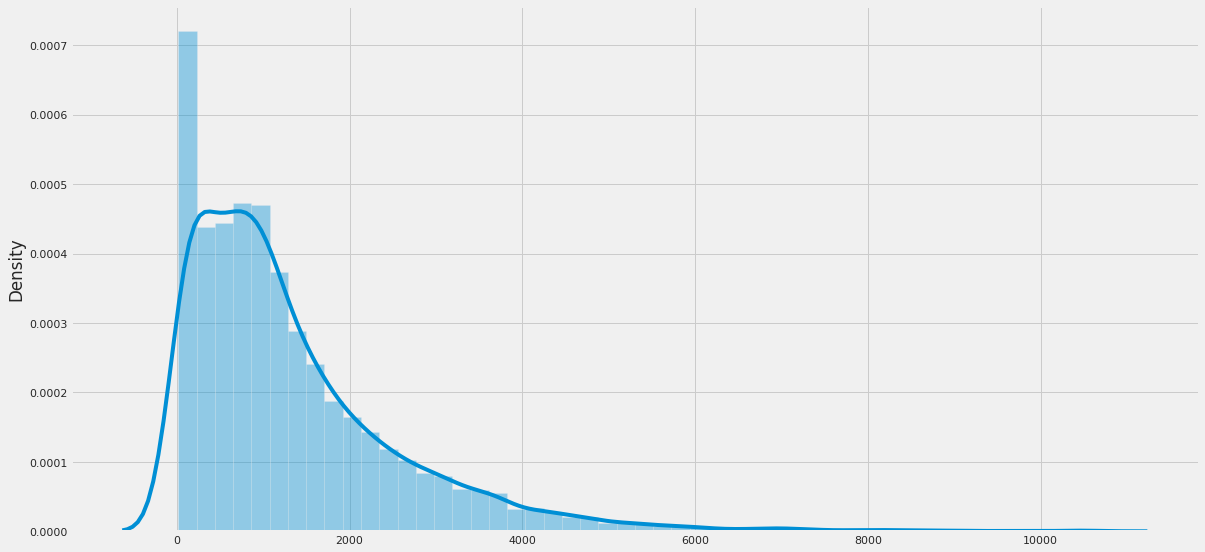

In [463]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [464]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df


(62442, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,VOLCKER while but it may be that itsurprised me that they werewe don't have thatin our forecast I thought it had been level for a longgot back to where it was a year ago Itup that much in a year V...,[VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year....,200
1,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,the guy payingthe highest rate And that will tend to force the rates higher Iwould think there would be two tendencies initially To pay a moneybill rate My guess would be that the bill rate fellow...,[VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year....,200
2,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,going on particularly with respect to Argentina andYugoslavia of central banking monetary authority packages The is whether those packages are big enough for the situation inboth cases As I said t...,[VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year....,200
3,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,case of Mexico I don't know if it's goingto come up I hope it doesn't My position is that it should not comeup On the other hand I cannot exclude it given the nature of theproblem VOLCKER Let me s...,[VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year....,200
4,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,is affected by recession high interestBut I think it's patently obvious thatrates and all the rest Mexico was going to borrow all it could borrow and all the banks weregoing to give them and at so...,[VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year....,200
...,...,...,...,...,...,...,...,...,...,...,...,...
62437,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0,0.0,2016-01-27,0,0.25,as we think we cando so safely Although we refer to a rise in the federal funds rate target as a tightening ofmonetary policy and this harkens back to what Stan was saying there s a problem there ...,"[I have a question and I have an observation. Thequestion concerns the core PCE forecast on exhibit 4. Since October we’ve seen a strongerdollar, weaker oil prices, and probably a slightly weaker ...",200
62438,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0,0.0,2016-01-27,0,0.25,monetary policy to the real economy works through thetransmission channel of financial market conditions So if it s like the taper tantrum episode andif financial conditions were to tighten signif...,"[I have a question and I have an observation. Thequestion concerns the core PCE forecast on exhibit 4. Since October we’ve seen a strongerdollar, weaker oil prices, and probably a slightly weaker ...",200
62439,meeting_script,2014-12-17,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,0,0.0,2016-01-27,0,0.25,might be quite poorat first In my mind raising short term rates for the first time in more than six years is asubstantial regime shift Finally given all of the uncertainties about how financial co...,"[I have a question and I have an observation. Thequestion concerns the core 

### Filter out by keywords

In [465]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=False, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df


(4698, 13)


,index,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,0,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMA,-1,9.5,1982-11-16,-1,9.00,"VOLCKER.I think there will be a tendency amongsome to pay a money market funds rate plus; the question is whetherthe market gets driven there.I'm just guessing. Among other things,we approved what...","[VOLCKER.I think there will be a tendency amongsome to pay a money market funds rate plus; the question is whetherthe market gets driven there.I'm just guessing. Among other things,we approved wha...",165
1,1,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.00,"I will mention one other aspect of thisand then I want to go back to somewhat broader subjects.If there isa big drain on money market funds, there probably will be a big drainon bank CDs.Money mar...","[I will mention one other aspect of thisand then I want to go back to somewhat broader subjects.If there isa big drain on money market funds, there probably will be a big drainon bank CDs.Money ma...",4593
2,5,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BOEHNE,-1,9.5,1982-11-16,-1,9.00,"Well, I think how one comes out on this dependson whether one wants to take the risks on rules or on the side ofdiscretion.It does seem to me that we have pushed the domesticeconomy and the financ...","[Well, I think how one comes out on this dependson whether one wants to take the risks on rules or on the side ofdiscretion.It does seem to me that we have pushed the domesticeconomy and the finan...",179
3,7,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. CORRIGAN,-1,9.5,1982-11-16,-1,9.00,"Mr. Chairman, I clearly would fall on the sideof the argument that says we don't want an increase in interest rates,even by accident.An increase in interest rates in the currentsetting, even if it...","[Mr. Chairman, I clearly would fall on the sideof the argument that says we don't want an increase in interest rates,even by accident.An increase in interest rates in the currentsetting, even if i...",247
4,8,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. FORD,-1,9.5,1982-11-16,-1,9.00,"What you are saying quite plainly, if I hear youcorrectly, is that you think rates are too high now and you don't wanteven a tiny increase from the present rate of 10-1/4 percent on thefed funds r...","[What you are saying quite plainly, if I hear youcorrectly, is that you think rates are too high now and you don't wanteven a tiny increase from the present rate of 10-1/4 percent on thefed funds ...",42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,6832,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. GEORGE,0,0.0,2016-01-27,0,0.25,"Thank you, Madam Chair. The Tenth District economy has continued toexpand at a relatively steady pace, with the exception of energy and agricultural production.Most of our industry contacts note p...","[Thank you, Madam Chair. The Tenth District economy has continued toexpand at a relatively steady pace, with the exception of energy and agricultural production.Most of our industry contacts note ...",721
4694,6833,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. KLEE,0,0.0,2016-01-27,0,0.25,4 Thank you. I will be referring to the packet labeled “Material forBriefing on the Summary of Economic Projections.”Exhibit 1 shows the broad trajectories of your forecasts under your individuala...,[4 Thank you. I will be referring to the packet labeled “Material forBriefing on the Summary of Economic Projections.”Exhibit 1 shows the broad trajectories of your forecasts under your individual...,1096
4695,6834,meeting_script,2014-12-17,FOMC Meeting Transcript,MS. LOGAN,0,0.0,2016-01-27,0,0.25,"Thank you, Madam Chair. I’ll begin again on exhibit 3 with asummary of the recent testing of the term deposit facility and reverse repos, and astaff proposal to continue ON RRP testing in 2015. Th...","[Thank you, Madam Chair. I’ll begin 

In [466]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech

In [467]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1500
Shape of the dataframe:  (1500, 13)


In [468]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3211,<NA>,None,1996-07-03,0,5.25,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2694,<NA>,None,1996-07-03,0,5.25,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2902,<NA>,None,1996-09-24,0,5.25,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1988,<NA>,None,1996-09-24,0,5.25,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2180,<NA>,None,1996-11-13,0,5.25,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,speech,2020-12-18,Strengthening the Financial System to Meet the Challenge of Climate Change,Governor Lael Brainard,2421,<NA>,None,2021-01-27,0,NaN,"The Federal Reserve, the central bank of the United Stat

(1500, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


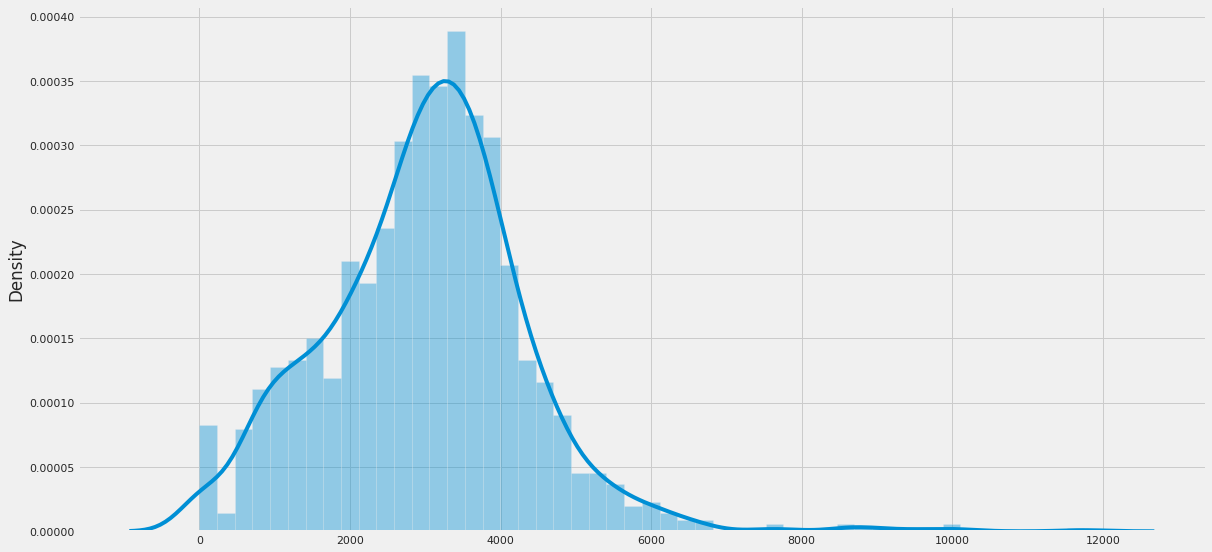

In [469]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [470]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [471]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3095,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2659,<NA>,None,1996-07-03,0,5.25,"It is a pleasure to be here this afternoon to provide the Federal Reserve's perspective on recent developments in the field of electronic money and banking. To begin, let me remind yo...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2729,<NA>,None,1996-09-24,0,5.25,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1586,<NA>,None,1996-09-24,0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2002,<NA>,None,1996-11-13,0,5.25,"A fair question might be, what is the nation's central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,speech,2020-12-18,Strengthening the Financial System to Meet the Challenge of Climate Change,Governor Lael Brainard,2200,<NA>,None,2021-01-27,0,NaN,I want to thank the Center for American Progress for inviting me to join you in discussing 

In [472]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(430, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,3095,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-09-19,Regulation and electronic payment systems,Alan Greenspan,1586,<NA>,None,1996-09-24,0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,2183,<NA>,None,1996-11-13,0,5.25,You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value. I hope that by the end of my remarks thismorning it will be clear t...,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996, , You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-07,U.S. Treasury securities market: Lessons from Alexander Hamilton,Alan Greenspan,985,<NA>,None,1996-11-13,0,5.25,I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service. I am particularly honored by the company that I keep as a winner of thi...,"[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
4,speech,1996-10-16,Technological advances and productivity,Alan Greenspan,1615,<NA>,None,1996-11-13,0,5.25,The Conference Board has been an important institution in my life. It was where I started as an economist. It was where I came into contact with a business world I had never known before. The y...,"[Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996, , It is a pleasure to b...","Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,speech,2020-05-13,Current Economic Issues,Jerome Powell,1206,<NA>,None,2020-06-10,0,0.00,"The coronavirus has left a devastating human and economic toll in its wake as it has spread around the globe. This is a worldwide public health crisis, and health-care work

### Split contents to max 200 words

In [473]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(7086, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7081,speech,2020-10-06,Recent Economic Developments and the Challenges Ahead,Jerome Powell,200,<NA>,None,2020-11-05,0,NaN,controlling the spread and effects of the virus There is a risk that the rapid initial gains from reopening may transition to a longer than expected slog back to full recov

### Filter out by keyword

In [474]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(221, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,136,<NA>,None,1996-11-13,0,5.25,"While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing shareh...","[While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing share...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
1,speech,1996-12-06,Social security,Alan Greenspan,253,<NA>,None,1996-12-17,0,5.25,"While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....","[While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years...","\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif..."
2,speech,1997-01-14,Central banking and global finance,Alan Greenspan,133,<NA>,None,1997-02-05,0,5.25,"In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at le...","[In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at l...","\n\n[SECTION]\n\nCentral Banking and Global Finance\n\n[SECTION]\n\nMr. Prime Minister, Minister of Finance, Minister of Budget, Rector Oosterlinck,\r\nProfessor Peeters, ladies and gentlemen, it ..."
3,speech,1997-02-21,Government regulation and derivative contracts,Alan Greenspan,212,<NA>,None,1997-03-25,1,5.50,"In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...","[In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identifie...","I am pleased to participate once again in the Federal Reserve Bank of Atlanta's annual Financial Markets Conference. As in previous years, the Reserve Bank has developed a conference program that..."
4,speech,1997-04-29,G-7 economic summit meeting,Alan Greenspan,142,<NA>,None,1997-05-20,0,5.50,"In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at ...","[In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at...","\n\n[SECTION]\n\nIt is a pleasure to be here today.\n\n[SECTION]\n\nI will take this occasion to offer some thoughts related to the upcoming G-7 economic summit meeting, which will be held in Denv..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,speech,2019-10-09,Opening Remarks,Jerome Powell,150,<NA>,None,2019-10-30,-1,1.50,"Now is a good time to conduct the review. Unemployment is at a half-century low, and inflation is running close to, but a bit below, our 2 percent objective. While not everyone fully shares econom...","[Now is a good ti

In [475]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony

In [476]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  443
Shape of the dataframe:  (443, 13)


In [477]:
# Check the returned dataframe
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2298,<NA>,None,1996-07-03,0,5.25,[SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent pub...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",1227,<NA>,None,1996-08-20,0,5.25,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past s...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,3372,<NA>,None,1996-08-20,0,5.25,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2878,<NA>,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in thi...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3764,<NA>,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,testimony,2020-09-08,Diversity and Inclusion,"Testimony by Sheila Clark, Program Director, Office of Diversity and Inclusion",687,<NA>,None,2020-09-16,0,NaN,"The Federal Reserve, the centra

(443, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


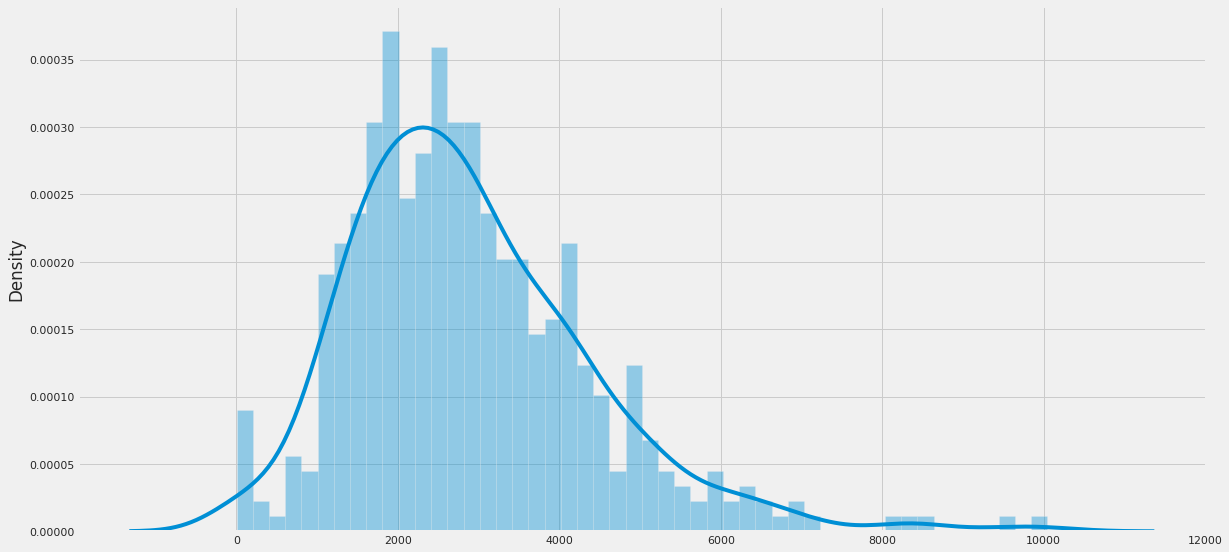

In [478]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [479]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [480]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,<NA>,None,1996-07-03,0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,<NA>,None,1996-08-20,0,5.25,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,2966,<NA>,None,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,<NA>,None,1996-08-20,0,5.25,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3308,<NA>,None,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,testimony,2020-09-08,Diversity and Inclusion,"Testimony by Sheila Clark, Program Director, Office of Diversity and Inclusion",483,<NA>,None,2020-09-16,0,NaN,"Chair Beatty, Ranking Member W

In [481]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,2966,<NA>,None,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3308,<NA>,None,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,2854,<NA>,None,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997, Mr. Chairman and members of the Committee, I am please...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-01-30,The comsumer price index,Alan Greenspan,2692,<NA>,None,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today. The Committee is faced with a number of complex policy issues that will have an important beari...","[Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997, Mr. Chairman and members of the Committee, I appreciate the oppo...","Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe..."
4,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4100,<NA>,None,1997-03-25,1,5.50,"Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...","[Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,...",Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,<NA>,None,2020-06-10,0,0.00,"I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around the world. The coronavirus o

### Split contents to max 200 words

In [482]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


(2850, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
4,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,0,5.25,less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security Act",Jerome Powell,200,<NA>,None,2020-12-16,0,NaN,by U S listed exchange traded funds ETFs whose investment objective is to provide broad ex

### Filter out by keyword

In [483]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(125, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,628,<NA>,None,1996-08-20,0,5.25,"Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pric...","[Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pri...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,549,<NA>,None,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
2,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,286,<NA>,None,1997-03-25,1,5.50,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy prog...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
3,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,<NA>,None,1997-03-25,1,5.50,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
4,testimony,1997-07-22,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,1068,<NA>,None,1997-08-19,0,5.50,This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,[This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 22, 1997\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,testimony,2020-02-11,Semiannual Monetary Policy Report to the Congress,Jerome Powell,544,<NA>,None,2020-03-03,-1,1.00,"Gross domestic product rose at a moderate rate over the second half of last year. Growth in consumer spending moderated toward the end of the year following earlier strong increases, but the funda...","[Gross dome

In [484]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [485]:
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [486]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=preprocessed_dir, index_csv=True):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

else:
  def save_data(df, file_name, dir_name=preprocessed_dir):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

In [487]:
save_data(text_no_split, 'text_no_split')

Successfully saved text_no_split.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/text_no_split.pickle
Successfully saved text_no_split.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/text_no_split.csv


In [488]:
save_data(text_split_200, 'text_split_200')

Successfully saved text_split_200.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/text_split_200.pickle
Successfully saved text_split_200.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/text_split_200.csv


In [489]:
save_data(text_keyword, 'text_keyword')

Successfully saved text_keyword.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/text_keyword.pickle
Successfully saved text_keyword.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/text_keyword.csv
